# Stochastic SEIRD model using odin
<i>Thibaut Jombart</i>, 3rd October 2018


## Requirements
This code uses [*odin*](https://github.com/mrc-ide/odin), an **R** package for describing an solving differential equations. The following commands will install the latest version of the package and its dependencies:

In [1]:
if (!require("drat")) install.packages("drat")
drat:::add("mrc-ide")
install.packages("dde")
install.packages("odin")


Loading required package: drat
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


We also use the following helper functions:

In [2]:
## function to make colors transparent, stolen from adegenet::transp
transp <- function (col, alpha = 0.5) {
    res <- apply(col2rgb(col), 2,
                 function(c) rgb(c[1]/255, c[2]/255, 
                                 c[3]/255, alpha))
    return(res)
}

## x: instance of odin model
## t: time steps
## n: number of replicates
run_model <- function(x, t = 0:100, n = 1, ...) {
    res <- x$run(t, replicate = n, ...)
    res <- x$transform_variables(res)
    res <- cbind.data.frame(t = res[[1]], res[-1])
    attr(res, "n_compartments") <- length(x$names) - 1
    attr(res, "n_replicates") <- n
    attr(res, "compartments") <- x$names[-1]
    class(res) <- c("pretty_odin", class(res))
    res
}


## plot function
plot.pretty_odin <- function(x, pal = seird_pal, ...) {
    ## handle colors
    n_compartments <- attr(x, "n_compartments")
    n_replicates <- attr(x, "n_replicates")
    col_leg <- pal(n_compartments)
    alpha <- max(10 / n_replicates, 0.05)
    col <- rep(transp(col_leg, alpha), each = n_replicates)

    ## make plot
    par(mar = c(4.1, 5.1, 0.5, 0.5), las = 3)
    matplot(x[, 1], x[, -1], xlab = "Time", ylab = "Number of individuals",
            type = "l", col = col, lty = 1, ...)
    legend("topright", lwd = 1, col = col_leg, bty = "n",
           legend = attr(x, "compartments"))
}

                 
## colors
seird_col <- c("#8c8cd9", "#e67300", "#d279a6", "#ff4d4d", "#999966", "#660000")
seird_pal <- colorRampPalette(seird_col)


## Model description

We assume familiarity with discrete stochastic models using [*odin*](https://github.com/mrc-ide/odin); for an introduction, check the discrete stochastic SIR  model on this website. 
The model is SEIRD model, where infected individuals can survive or die at different rates, with waning immunity. The full model specification is:

- $S$: susceptibles
- $E$: exposed, i.e. infected but not yet contagious
- $I_R$: infectious who will survive
- $I_D$: infectious who will die
- $R$: recovered
- $D$: dead


There are no birth of natural death processes in this model. Parameters are:

- $\beta$: rate of infection
- $\delta$: rate at which symptoms appear (i.e inverse of mean incubation
period)
- $\gamma_R$: recovery rate
- $\gamma_D$: death rate
- $\mu$: case fatality ratio (proportion of cases who die)
- $\epsilon$: import rate of infected individuals (applies to $E$ and $I$)
- $\omega$: rate waning immunity


The model will be written as:

$$
S_{t+1} = S_t - \beta \frac{S_t (I_{R,t} + I_{D,t})}{N_t} + \omega R_t
$$

$$
E_{t+1} = E_t + \beta \frac{S_t (I_{R,t} + I_{D,t})}{N_t} - \delta E_t + \epsilon
$$

$$
I_{R,t+1} = I_{R,t} + \delta (1 - \mu) E_t - \gamma_R I_{R,t} + \epsilon
$$

$$
I_{D,t+1} = I_{D,t} + \delta \mu E_t - \gamma_D I_{D,t} + \epsilon
$$

$$
R_{t+1} = R_t + \gamma_R I_{R,t} - \omega R_t
$$

$$
D_{t+1} = D_t + \gamma_D I_{D,t}
$$



The model is specified in *odin* using:

In [3]:
seird_generator <- odin::odin({
  ## Core equations for transitions between compartments:
  update(S) <- S - n_SE + n_RS
  update(E) <- E + n_SE - n_EI + n_import_E
  update(Ir) <- Ir + n_EIr - n_IrR
  update(Id) <- Id + n_EId - n_IdD
  update(R) <- R + n_IrR - n_RS
  update(D) <- D + n_IdD

  ## Individual probabilities of transition:
  p_SE <- 1 - exp(-beta * I / N)
  p_EI <-  1 - exp(-delta)
  p_IrR <- 1 - exp(-gamma_R) # Ir to R
  p_IdD <- 1 - exp(-gamma_D) # Id to d
  p_RS <- 1 - exp(-omega) # R to S


  ## Draws from binomial distributions for numbers changing between
  ## compartments:
  n_SE <- rbinom(S, p_SE)
  n_EI <- rbinom(E, p_EI)

  n_EIrId[] <- rmultinom(n_EI, p)
  p[1] <- 1 - mu
  p[2] <- mu
  dim(p) <- 2
  dim(n_EIrId) <- 2
  n_EIr <- n_EIrId[1]
  n_EId <- n_EIrId[2]
  n_IrR <- rbinom(Ir, p_IrR)
  n_IdD <- rbinom(Id, p_IdD)

  n_RS <- rbinom(R, p_RS)

  n_import_E <- rpois(epsilon)

  ## Total population size, and number of infecteds
  I <- Ir + Id
  N <- S + E + I + R + D

  ## Initial states
  initial(S) <- S_ini
  initial(E) <- E_ini
  initial(Id) <- 0
  initial(Ir) <- 0
  initial(R) <- 0
  initial(D) <- 0

  ## User defined parameters - default in parentheses:
  S_ini <- user(1000) # susceptibles
  E_ini <- user(1) # infected
  beta <- user(0.3) # infection rate
  delta <- user(0.2) # inverse incubation period
  gamma_R <- user(0.2) # recovery rate
  gamma_D <- user(0.4) # death rate
  mu <- user(0.05) # CFR
  omega <- user(0.1) # rate of waning immunity
  epsilon <- user(0.05) # import case rate
    
  }, verbose = FALSE)

## Running the model
The model is first parsed and compiled using `odin::odin`, and user-provided parameters are passed using the resulting model generator (the object `seird_generator`). All parameters specified in the model description above as `user()` can be set through the model generator. Here, we use 1 initial exposed individual, 1 million susceptibles, and run 100 independent simulations: 

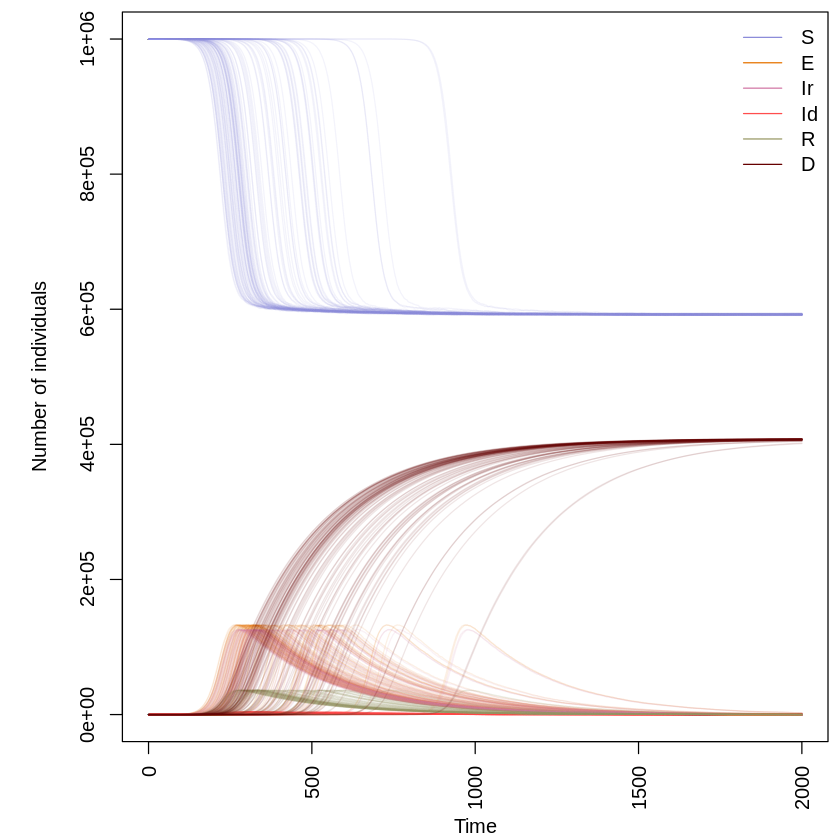

In [5]:
set.seed(1)
seird <- seird_generator(S_ini = 1e6, E_ini = 1, epsilon = 0.01, omega = 1)
x <- run_model(seird, t = 0:2000, n = 100)
plot(x)